# How to submit the homework
This homework has been provided to you as an .ipynb. We expect you to complete the notebook and submit the following on canvas:

* the completed notebook itself with your answers filled in (including any source code used to answer the question)

* a .pdf file of the notebook that shows all your answers. This will make grading easier and I will appreciate that. 

If you submit only one of these, you will lose points. No late homework will be graded. No submissions via email or other media will be graded.



---


# Question 1 (1 point)





Is the following module capable of implementing the function $y= x_1+x_2$  for all  $y,x_1,x_2 \in {\Bbb R}$ ? If so, explain why. If not, explain why not and provide a modified *AddModule* that can implement this function, given the right weights. Also, give a set of weights (including the bias) that would make the (possibly modified) *AddModule*  actually implement $y= x_1+x_2$.

```
class AddModule(torch.nn.Module):

  # Define the model architecture
  def __init__(self, use_good_weights=False):
    super(AddModule, self).__init__()

    self.layer_1 = torch.nn.Linear(2,1)

  def forward(self, x):
      return torch.nn.Hardtanh(self.layer_1(x))
```

***YOUR ANSWER GOES HERE***

No, it cannot implement this function. We could take out the hardtanh activation function and this module would be able to implement function $y = x_1 + x_2$.

Yes. The input size is 2 because each data sample $x_i = <x_1, x_2>$ has two dimensions. The linear layer applies a linear transformation to the input, which is $y = w^Tx + b$, and we will have two weights and one bias term to be learned. The output dimension is 1, which corresponds with the target $y$ dimension. The activation function for this single layer is Hardtanh, where it is defined as the following: 

$
\begin{equation}
  f(x)=\begin{cases}
    1, & \text{if $x>1$}.\\
    -1, & \text{if $x<-1$}.\\
    x, & \text{otherwise}
  \end{cases}
\end{equation}
$

This activation function also return a real number, which corresponds to the target output. Therefore, this module can implement the function $y = x_1 + x_2$ with correct weights. 

# Question 2 (3 points)

In this question, you will do your best to make a network to embody the function $y=x_1 * x_2$. Here, assume $x_1,x_2 \in {\Bbb R}$ and $x_1,x_2 \in (-1000,1000)$. 

Assume you are starting from random weight initialization. Feel free to use any of the Non-linear Activations (weighted sum, nonlinearity) in [torch.nn](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). Use as many layers as you like. Make the layers as big as you like. 

* Note, you are not allowed to simply put some variant of $output = x_1*x_2$ in your forward function.

You will make a training dataset and a test dataset using the provided dataset generator. Train the network on the training set and, once trained, test it on the test data. Make sure your test set is at minimum 1000 examples. Use mean-squared-error as your objective function. Then answer the following questions.

1. What was the best mean-squared-error you got on the training data?

The best MSE I got is 0.5883486866950989.

1. What was the best mean-squared-error you got on the test data?

The best MSE I got is 0.6079967617988586.

1. What challenges or difficulties did you encounter in implementing and training this network?

At the beginning, I struggled with the huge loss that I got in each run, and I was also confused by why the loss converges to some large number immediately after one or two epoch. This might be caused by large gradients and loss added on top of each other, and so the error became huge.

Later, I found out that I did not scale my data properly, and when I was using tanh as my activation function, it automatically convert my hugh input to 1 and -1. Therefore, I decided to scale both the data and the labels by dividing 1000 and 1000000 respectively so that they fall within $[-1, 1]$ and so that the tanh activation function could be properly applied. 

I also tried other transformation on data, like log transformation. But since applying log on negative values would cause undefined, we cannot use this transformation. 

***YOUR ANSWER GOES HERE***


In [82]:
import sys
#sys.path.append('/Users/yujiaxie/.pyenv/versions/3.9.4/lib/python3.9/site-packages')

In [85]:
# HERE'S A DATASET GENERATOR TO HELP YOU TEST/TRAIN.
import torch
import numpy as np
class MultiplyDataset(torch.utils.data.Dataset):
    """MULTIPLY Dataset."""

    def __init__(self, num_examples, max_abs=1000):
        """create a dataset of the form x_1 * x_2 = y. The input x_1, x_2 is a 
        pair of values drawn from the default range [-1000, 1000]. The output y is a scalar.
  
        PARAMETERS
        ----------
        num_examples    An integer determining how much data we'll generate
        max_abs         The largest absolute value a datapoint can have
        """
        self.length = num_examples

        # make a circular unit Gaussian and draw samples from it
        data = np.random.multivariate_normal(mean=[0,0],cov=[[1,0],[0,1]],size=self.length)

        data *= max_abs
        # figure out the label (i.e. the result of the multiplication)
        label = np.multiply(data.T[0],data.T[1])

        # turn it into a tensor
        self.data =  torch.tensor(data).to(dtype=torch.float32)
        self.label = torch.tensor(label).to(dtype=torch.float32) 
       
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [87]:
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
# install common pacakges used for deep learning
!cd course-deep-learning/ && pip install -r requirements.txt
%cd course-deep-learning/

Cloning into 'course-deep-learning'...
remote: Enumerating objects: 342, done.
remote: Total 342 (delta 0), reused 0 (delta 0), pack-reused 342
Receiving objects: 100% (342/342), 119.02 MiB | 7.53 MiB/s, done.
Resolving deltas: 100% (156/156), done.


/Users/yujiaxie/Desktop/northwestern/CS496DL/course-deep-learning/course-deep-learning


In [88]:
# YOUR CODE GOES HERE

%matplotlib inline
import matplotlib.pyplot as plt
from utils.plotting import *  # see plotting.py for plotting utilities
from utils.data import * 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [110]:
class Q2Net(torch.nn.Module): 
    def __init__(self):
        super().__init__() # has to be here
        self.fc1 = nn.Linear(2,100) # this accepts 2 dim input and returns 3 dim output
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    # This part determines how data in x flows through the network. 
    # Here, x is the input to the network. 
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        #x = torch.tanh(self.fc3(x))#output layer has to give a (400,1) vector that range from [-1, 1]
        return x

In [113]:
def train_model(model, data, target): 
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = F.mse_loss(output.squeeze(), target)
    loss.backward()
    optimizer.step()
    
def test_model(model, data, target): 
    model.eval()
    with torch.no_grad(): 
        prediction = model(data)
        prediction = prediction.squeeze() 
        loss = F.mse_loss(prediction, target)
        loss = round(loss.item(),4)
        return loss

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(train_y).to(dtype=torch.float32)


Epoch: 0 Loss: 1.252996563911438
Epoch: 100 Loss: 0.7155877947807312
Epoch: 200 Loss: 0.679847240447998
Epoch: 300 Loss: 0.6791032552719116
Epoch: 400 Loss: 0.6788431406021118
Epoch: 500 Loss: 0.6786931753158569
Epoch: 600 Loss: 0.6785837411880493
Epoch: 700 Loss: 0.6784943342208862
Epoch: 800 Loss: 0.6784161925315857
Epoch: 900 Loss: 0.6783447861671448
Epoch: 1000 Loss: 0.6782801151275635
Epoch: 1100 Loss: 0.6782214641571045
Epoch: 1200 Loss: 0.6781686544418335
Epoch: 1300 Loss: 0.6781214475631714
Epoch: 1400 Loss: 0.6780779361724854
Epoch: 1500 Loss: 0.6780378222465515
Epoch: 1600 Loss: 0.6780003309249878
Epoch: 1700 Loss: 0.6779647469520569
Epoch: 1800 Loss: 0.6779301166534424
Epoch: 1900 Loss: 0.6778973937034607


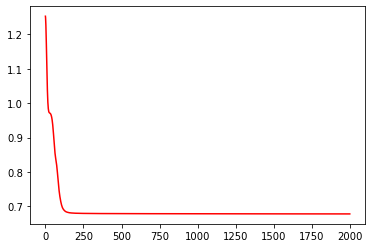

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.0949])
Expected: 0.16238191723823547
Test Loss: 0.7464182376861572
Epoch: 0 Loss: 1.188235878944397
Epoch: 100 Loss: 0.6973316073417664
Epoch: 200 Loss: 0.6060769557952881
Epoch: 300 Loss: 0.6047709584236145
Epoch: 400 Loss: 0.6044396758079529
Epoch: 500 Loss: 0.6042860746383667
Epoch: 600 Loss: 0.6041932702064514
Epoch: 700 Loss: 0.6041247248649597
Epoch: 800 Loss: 0.6040660738945007
Epoch: 900 Loss: 0.6040124297142029
Epoch: 1000 Loss: 0.6039613485336304
Epoch: 1100 Loss: 0.6039125919342041
Epoch: 1200 Loss: 0.6038639545440674
Epoch: 1300 Loss: 0.6038160920143127
Epoch: 1400 Loss: 0.6037660837173462
Epoch: 1500 Loss: 0.603715717792511
Epoch: 1600 Loss: 0.6036672592163086
Epoch: 1700 Loss: 0.6036219596862793
Epoch: 1800 Loss: 0.6035758852958679
Epoch: 1900 Loss: 0.6035281419754028


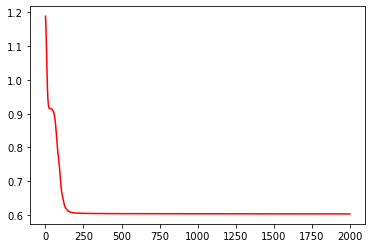

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.0272])
Expected: -0.26253020763397217
Test Loss: 0.6217109560966492
Epoch: 0 Loss: 1.2110259532928467
Epoch: 100 Loss: 0.6410008072853088
Epoch: 200 Loss: 0.5905435681343079
Epoch: 300 Loss: 0.5894690155982971
Epoch: 400 Loss: 0.5891934633255005
Epoch: 500 Loss: 0.5890565514564514
Epoch: 600 Loss: 0.5889652371406555
Epoch: 700 Loss: 0.5888912677764893
Epoch: 800 Loss: 0.5888274908065796
Epoch: 900 Loss: 0.58877032995224
Epoch: 1000 Loss: 0.5887168645858765
Epoch: 1100 Loss: 0.5886672139167786
Epoch: 1200 Loss: 0.5886220932006836
Epoch: 1300 Loss: 0.5885791778564453
Epoch: 1400 Loss: 0.5885380506515503
Epoch: 1500 Loss: 0.5884989500045776
Epoch: 1600 Loss: 0.5884605646133423
Epoch: 1700 Loss: 0.5884226560592651
Epoch: 1800 Loss: 0.5883853435516357
Epoch: 1900 Loss: 0.5883486866950989


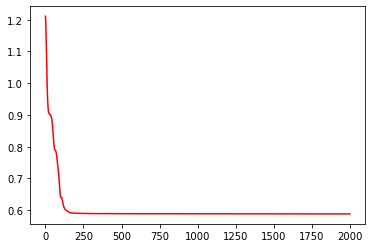

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.1651])
Expected: 0.2331356704235077
Test Loss: 0.6283020377159119
Epoch: 0 Loss: 1.2951470613479614
Epoch: 100 Loss: 0.7166587710380554
Epoch: 200 Loss: 0.690677285194397
Epoch: 300 Loss: 0.6901191473007202
Epoch: 400 Loss: 0.6899202466011047
Epoch: 500 Loss: 0.6898022294044495
Epoch: 600 Loss: 0.6897123456001282
Epoch: 700 Loss: 0.689633846282959
Epoch: 800 Loss: 0.6895616054534912
Epoch: 900 Loss: 0.6894937753677368
Epoch: 1000 Loss: 0.6894286870956421
Epoch: 1100 Loss: 0.6893665790557861
Epoch: 1200 Loss: 0.6893067955970764
Epoch: 1300 Loss: 0.6892496347427368
Epoch: 1400 Loss: 0.6891950964927673
Epoch: 1500 Loss: 0.6891428828239441
Epoch: 1600 Loss: 0.6890920996665955
Epoch: 1700 Loss: 0.6890435814857483
Epoch: 1800 Loss: 0.6889983415603638
Epoch: 1900 Loss: 0.6889556646347046


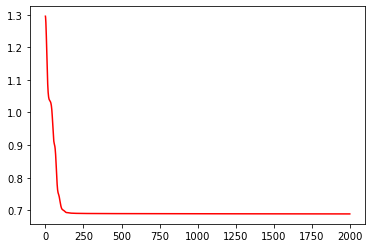

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.9991])
Expected: 1.958646297454834
Test Loss: 0.6399846076965332
Epoch: 0 Loss: 1.3053832054138184
Epoch: 100 Loss: 0.7602070569992065
Epoch: 200 Loss: 0.7046449184417725
Epoch: 300 Loss: 0.7035305500030518
Epoch: 400 Loss: 0.7032220959663391
Epoch: 500 Loss: 0.7030715346336365
Epoch: 600 Loss: 0.7029759287834167
Epoch: 700 Loss: 0.7029018998146057
Epoch: 800 Loss: 0.7028367519378662
Epoch: 900 Loss: 0.7027781009674072
Epoch: 1000 Loss: 0.7027227282524109
Epoch: 1100 Loss: 0.7026715874671936
Epoch: 1200 Loss: 0.7026217579841614
Epoch: 1300 Loss: 0.7025731205940247
Epoch: 1400 Loss: 0.7025274634361267
Epoch: 1500 Loss: 0.7024842500686646
Epoch: 1600 Loss: 0.7024430632591248
Epoch: 1700 Loss: 0.702402651309967
Epoch: 1800 Loss: 0.7023630738258362
Epoch: 1900 Loss: 0.702325165271759


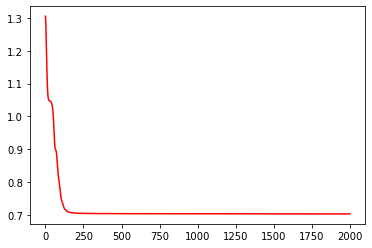

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.1808])
Expected: 0.20357760787010193
Test Loss: 0.7336829304695129
Epoch: 0 Loss: 1.256528377532959
Epoch: 100 Loss: 0.7031880617141724
Epoch: 200 Loss: 0.6702548265457153
Epoch: 300 Loss: 0.6694421172142029
Epoch: 400 Loss: 0.6691703796386719
Epoch: 500 Loss: 0.6690289974212646
Epoch: 600 Loss: 0.6689354181289673
Epoch: 700 Loss: 0.6688612699508667
Epoch: 800 Loss: 0.6687955856323242
Epoch: 900 Loss: 0.6687343716621399
Epoch: 1000 Loss: 0.668674111366272
Epoch: 1100 Loss: 0.6686146259307861
Epoch: 1200 Loss: 0.6685563325881958
Epoch: 1300 Loss: 0.6685017347335815
Epoch: 1400 Loss: 0.6684504151344299
Epoch: 1500 Loss: 0.6684002876281738
Epoch: 1600 Loss: 0.6683527231216431
Epoch: 1700 Loss: 0.6683073043823242
Epoch: 1800 Loss: 0.6682643890380859
Epoch: 1900 Loss: 0.6682244539260864


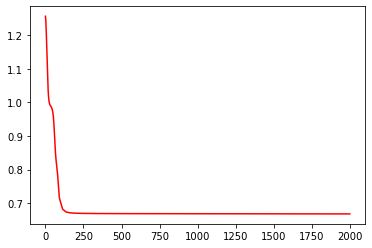

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.0193])
Expected: -0.11936389654874802
Test Loss: 0.6778024435043335
Epoch: 0 Loss: 1.2020434141159058
Epoch: 100 Loss: 0.642698347568512
Epoch: 200 Loss: 0.6176808476448059
Epoch: 300 Loss: 0.6169664263725281
Epoch: 400 Loss: 0.6167298555374146
Epoch: 500 Loss: 0.6166060566902161
Epoch: 600 Loss: 0.6165238618850708
Epoch: 700 Loss: 0.6164613962173462
Epoch: 800 Loss: 0.616408109664917
Epoch: 900 Loss: 0.616359531879425
Epoch: 1000 Loss: 0.6163142323493958
Epoch: 1100 Loss: 0.6162717342376709
Epoch: 1200 Loss: 0.6162307858467102
Epoch: 1300 Loss: 0.6161919832229614
Epoch: 1400 Loss: 0.6161551475524902
Epoch: 1500 Loss: 0.6161200404167175
Epoch: 1600 Loss: 0.6160855293273926
Epoch: 1700 Loss: 0.6160517930984497
Epoch: 1800 Loss: 0.6160187721252441
Epoch: 1900 Loss: 0.6159850358963013


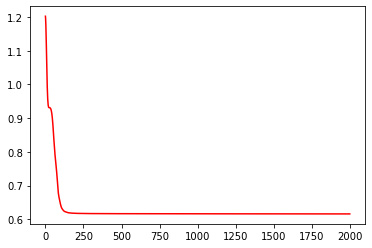

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.0077])
Expected: -0.01700027659535408
Test Loss: 0.6079967617988586
Epoch: 0 Loss: 1.2429628372192383
Epoch: 100 Loss: 0.6855932474136353
Epoch: 200 Loss: 0.670116126537323
Epoch: 300 Loss: 0.6694228649139404
Epoch: 400 Loss: 0.669174313545227
Epoch: 500 Loss: 0.6690422892570496
Epoch: 600 Loss: 0.6689543724060059
Epoch: 700 Loss: 0.6688864827156067
Epoch: 800 Loss: 0.6688293218612671
Epoch: 900 Loss: 0.6687790155410767
Epoch: 1000 Loss: 0.6687320470809937
Epoch: 1100 Loss: 0.6686875224113464
Epoch: 1200 Loss: 0.6686449646949768
Epoch: 1300 Loss: 0.6686050295829773
Epoch: 1400 Loss: 0.6685659885406494
Epoch: 1500 Loss: 0.6685284376144409
Epoch: 1600 Loss: 0.6684920787811279
Epoch: 1700 Loss: 0.6684564352035522
Epoch: 1800 Loss: 0.6684210896492004
Epoch: 1900 Loss: 0.6683861613273621


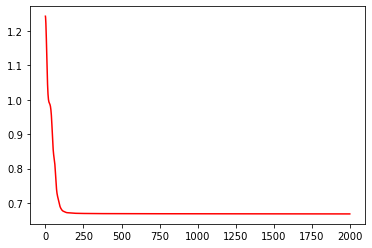

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([5.4297e-05])
Expected: -0.7601127028465271
Test Loss: 0.6196986436843872
Epoch: 0 Loss: 1.2982003688812256
Epoch: 100 Loss: 0.7957296371459961
Epoch: 200 Loss: 0.6323673129081726
Epoch: 300 Loss: 0.6290206909179688
Epoch: 400 Loss: 0.6284827589988708
Epoch: 500 Loss: 0.6282689571380615
Epoch: 600 Loss: 0.6281499862670898
Epoch: 700 Loss: 0.6280705332756042
Epoch: 800 Loss: 0.6280090808868408
Epoch: 900 Loss: 0.6279576420783997
Epoch: 1000 Loss: 0.6279124617576599
Epoch: 1100 Loss: 0.6278717517852783
Epoch: 1200 Loss: 0.6278335452079773
Epoch: 1300 Loss: 0.6277989745140076
Epoch: 1400 Loss: 0.6277662515640259
Epoch: 1500 Loss: 0.6277348399162292
Epoch: 1600 Loss: 0.6277042627334595
Epoch: 1700 Loss: 0.6276741623878479
Epoch: 1800 Loss: 0.6276447772979736
Epoch: 1900 Loss: 0.627615749835968


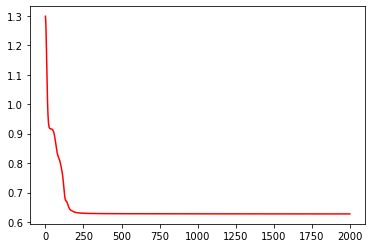

/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_x).to(dtype=torch.float32)
/var/

Prediction: tensor([0.1918])
Expected: 0.26450324058532715
Test Loss: 0.6464580297470093
Epoch: 0 Loss: 1.2346824407577515
Epoch: 100 Loss: 0.6726415157318115
Epoch: 200 Loss: 0.662228524684906
Epoch: 300 Loss: 0.6616369485855103
Epoch: 400 Loss: 0.6614211201667786
Epoch: 500 Loss: 0.6613009572029114
Epoch: 600 Loss: 0.66121506690979
Epoch: 700 Loss: 0.6611425876617432
Epoch: 800 Loss: 0.6610761880874634
Epoch: 900 Loss: 0.6610121726989746
Epoch: 1000 Loss: 0.6609495878219604
Epoch: 1100 Loss: 0.6608885526657104
Epoch: 1200 Loss: 0.6608300805091858
Epoch: 1300 Loss: 0.6607744097709656
Epoch: 1400 Loss: 0.6607216596603394
Epoch: 1500 Loss: 0.6606723070144653
Epoch: 1600 Loss: 0.6606245040893555
Epoch: 1700 Loss: 0.6605780124664307
Epoch: 1800 Loss: 0.6605333685874939
Epoch: 1900 Loss: 0.6604896187782288


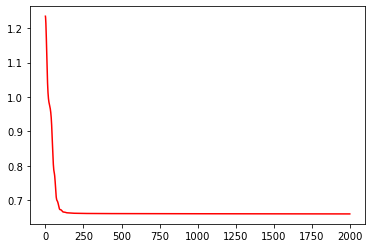

Prediction: tensor([0.7727])
Expected: 0.6838955879211426
Test Loss: 0.6692646741867065


/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_x = torch.tensor(test_x).to(dtype=torch.float32)
/var/folders/sl/wss32g7d5n90dkxvz70f3q940000gn/T/ipykernel_47160/1359735096.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_y = torch.tensor(test_y).to(dtype=torch.float32)


In [119]:
epochs = 2000

times = 10

for k in range(0, times): 
    # initialize a model and examine its weights
    net = Q2Net()

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.95)
    train = MultiplyDataset(5000)
    train_x = train[:][0]
    train_y = train[:][1]
    
    x = torch.tensor(train_x).to(dtype=torch.float32)
    y = torch.tensor(train_y).to(dtype=torch.float32)
    #apply data transformation 
    x = x / 1000
    y = y / 1000000
    
    #model training 
    losses = []
    for i in range(0,epochs):
        net.train()
        optimizer.zero_grad()
        output = net(x)
        loss = F.mse_loss(output.squeeze(), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 100 == 0: 
            print("Epoch: {} Loss: {}".format(i, loss.item()))


    plt.plot(np.linspace(0, epochs, epochs), losses, 'r')

    
    plt.show()
    
    test = MultiplyDataset(1000)
    test_x = test[:][0]
    test_y = test[:][1]   

    t_x = torch.tensor(test_x).to(dtype=torch.float32)
    t_y = torch.tensor(test_y).to(dtype=torch.float32)

    t_x = t_x / 1000
    t_y = t_y / 1000000

    # test the model
    net.eval()
    prediction = net(t_x)
    print("Prediction: {}".format(prediction.data[0]))
    print("Expected: {}".format(t_y[0]))
    print("Test Loss: {}".format(F.mse_loss(prediction.squeeze(), t_y).item()))

# Question 3 (2 points)

We're now going to think about how easy it is to solve the general multiplication problem for real numbers: $y= x_1*x_2$, when $x_1,x_2 \in {\Bbb R}$ are not bounded to the limited range (-1000,1000). 

Define a "simple" feed-forward neural network as one where each layer $l$ takes input from only the previous layer $l-1$.
Let's assume our simple feed-forward network only uses "standard" nodes, which take a weighted sum $z=\mathbf{w}^T\mathbf{x}$ of inputs $\mathbf{x}$, given weights $\mathbf{w}$, and then apply a differentiable activation function $f()$ to $z$. Example "standard" nodes include ReLu, Leaky ReLU, Sigmoid, TanH, and the linear/identity function.

Define "correctly" performing multiplication as estimating $\hat{y}= x_1*x_2$  to 2 decimal places of precision (i.e. $ |\hat{y}-y| < 0.01)$. Here, $\hat{y}$ is the network's result and $y$ is the true answer.

Is it possible to make a "simple" neural network that can correctly perform multiplication for any arbitrary pair $x_1,x_2 \in {\Bbb R}$? **Support your answer.** 

*Hint: Think about what a "standard" node calculates. Think about how you would implement multiplication using addition.* 


***YOUR ANSWER GOES HERE***

No, it is not possible for a network to learn multiplication. 

A standard node calculates a linear combination among the input variables, and we can rewrite multiplication as $log(ab) = log(a) + log(b)$. So essentially, after we apply log transformation on the dataset, we are actually making the algorithm to learn addtion rather than multiplication. A neural network in the form $f(x) = \sigma(Ax + b)$ without log tranformation on the data and labels would be insufficient because we could not represent multiplication with linear combination among the indenpendent variables. 

# Question 4 (2 points)

Suppose you want to build a fully convolutional network, YouNet, which converts an image with cropped ImageNet dimensions (256, 256), to MNIST dimensions (28, 28), and back to (256, 256). This network contains a convolutional layer that maps an image from (256, 256) -> (28, 28), and a transposed convolutional layer that maps an image from (28, 28) -> (256, 256). 

In [121]:
import torch
import torch.nn as nn

class YouNet(nn.Module):
    def __init__(self,
                 kernel_1: tuple[int, int],
                 kernel_2: tuple[int, int],
                 stride_1: tuple[int, int] = (1, 1),
                 stride_2: tuple[int, int] = (1, 1)):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_1, stride=stride_1)
        self.conv2 = nn.ConvTranspose2d(1, 1, kernel_2, stride=stride_2)
        
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        mnist = self.conv1(x)
        imagenet = self.conv2(mnist)
        return mnist, imagenet

1. Find valid kernel sizes for the convolutional layers when `stride=(1, 1)`.  By 'valid', we mean that using the kernel results in a `mnist.shape` and an `imagenet.shape` that pass the assert statement below.

In [133]:
kernel_1 = 229
kernel_2 = 229

network = YouNet(kernel_1, kernel_2)
mnist, imagenet = network(torch.zeros(1, 1, 256, 256))
assert mnist.shape == (1, 1, 28, 28)
assert imagenet.shape == (1, 1, 256, 256)

2. Find valid kernel sizes for when `stride=(8, 8)`

In [141]:
kernel_1 = 40
kernel_2 = 40

network = YouNet(kernel_1, kernel_2, stride_1=(8, 8), stride_2=(8, 8))
mnist, imagenet = network(torch.zeros(1, 1, 256, 256))

assert mnist.shape == (1, 1, 28, 28)
assert imagenet.shape == (1, 1, 256, 256)

3. Suppose instead of processing an image of size (256, 256) with the YouNet you implemented in part 2, you want to process an input image of size (257, 257). What would the sizes of the two processed output images be? Why doesn't the imagenet output have dimensionality (257, 257)? (Hint: Does the strided convolution process all the rows and columns of the original image?)

***YOUR ANSWER GOES HERE***

The size of mnist would be (28, 28) and the imagenet output would be (256, 256). This is because the strided convolution does not process all the rows and columns of the original image, and therefore the last row and column would be strided. 

4. Suppose you are processing an image of size (264, 264) with the YouNet implemented in part 2. What would be the sizes of the two processed images output by the network? For an image of this size, does the imagenet output have the same size as the input?

The mnist output has dimension (29, 29) and the imagenet out has dimension (264, 264). Therefore, the imagenet output does have the same size as the input.

***YOUR ANSWER GOES HERE***

In [143]:
kernel_1 = 40
kernel_2 = 40

network = YouNet(kernel_1, kernel_2, stride_1=(8, 8), stride_2=(8, 8))
mnist, imagenet = network(torch.zeros(1, 1, 264, 264))

print(mnist.shape, imagenet.shape)

torch.Size([1, 1, 29, 29]) torch.Size([1, 1, 264, 264])


# Question 5 (3 points)

The paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167v3.pdf) is in our class readings list and describes one of the most popular normalization approaches.  

Specifically, you are to reproduce the experiment in **section 4.1** of the paper, providing an output figure like **figure 1(a)**.

This means making a network module that has **the architecture described in section 4.1** of the paper. You will need to create two alternative versions of your network module: one model that has at least one batch normalization layer, another module that has no batch normalization layer. Pytorch provides a handy 
[function](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) or [two](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) to help with this. 

* Note, you don't have to duplicate their weight initializations. Using the default weight initializations is fine.

The famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset is available in [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html). You can download it just by declarng the dataset and specifying download=true. See the torchvision.dataset docs for more on that.

* Note, torchvision.datasets has both test and train datasets available for MNIST. 

* Note, they never specify in the paper HOW BIG the testing (I think they mean VALIDATION, actually) set they use is. Yours could be just a couple of hundred examples.

* Note that you don't have to run the test after every training step. Every 20 training steps would be fine.

1. Put your graph similar to **figure 1(a)** from the paper below.

***YOUR ANSWER GOES HERE***
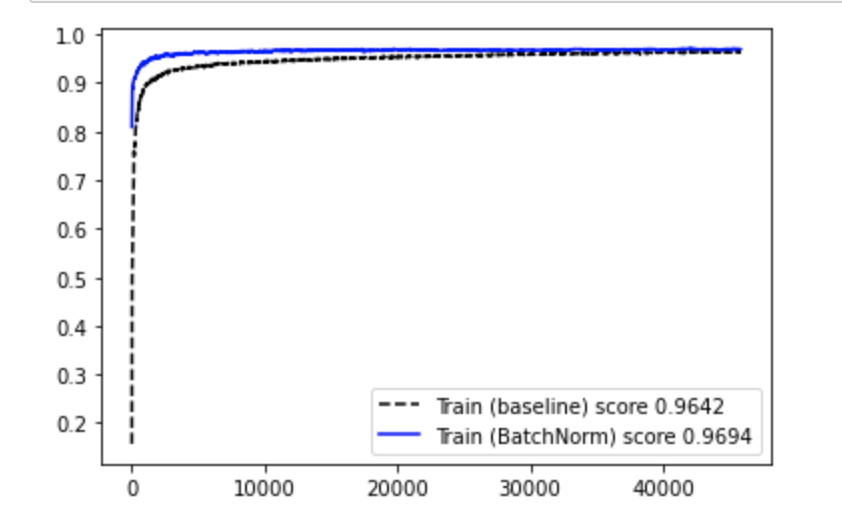

2. Put your analysis of the effectiveness of batch normalization for your network and dataset below. Did you duplicate their results?

***YOUR ANSWER GOES HERE***

Based on the graphs that I generated, it seems like Batch normalization does help making the distributions more stable and reducing the internal covariate shift. But in my case, it achieves a slightly higher test accuracy (96.94%) compared with the baseline model (96.06%) after 50 epochs. 

3. Put all your code (including network modules, data loaders, testing and training code) below. 

In [282]:
import time

In [299]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 10)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
net = Net()
net

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [295]:
class BNnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 10)
        self.sigmoid = torch.nn.Sigmoid()
        self.bn1 = torch.nn.BatchNorm1d(784)
        self.bn2 = torch.nn.BatchNorm1d(100)
        
    def forward(self, x):
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)
        x = self.sigmoid(self.fc1(self.bn1(x)))
        x = self.sigmoid(self.fc2(self.bn2(x)))
        x = self.sigmoid(self.fc3(self.bn2(x)))
        x = self.fc4(x)
        
        return x
    
bn = BNnet()
bn

BNnet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (bn1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [290]:
def training_loop(input_model, save_path, epochs, batch_size, device="cpu"):
    # initialize model
    model = input_model
    model.to(device)  # we'll cover this in the next section!

    # initialize an optimizer to update our model's parameters during training
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
    

    # make a new directory in which to download the MNIST dataset
    data_dir = "./data/"
    
    # initialize a Transform object to prepare our data
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        lambda x: x>0,
        lambda x: x.float(),
    ])

    # load MNIST "test" dataset from disk
    mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=False, transform=transform)

    # load MNIST "train" dataset from disk and set aside a portion for validation
    mnist_train_full = datasets.MNIST(data_dir, train=True, download=False, transform=transform)

    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 000])

    # initialize a DataLoader object for each dataset
    train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

    # a PyTorch categorical cross-entropy loss object
    loss_fn = torch.nn.CrossEntropyLoss()

    # time training process
    st = time.time()
    
    val_stat = [] 
    epoch_stat = []

    # time to start training!
    for epoch_idx, epoch in enumerate(range(epochs)):

        best_acc = 0.0

        train_loss = 0.0
        train_acc = 0.0
        train_total = 0
        model.train()
        for batch_idx, batch in enumerate(train_dataloader):

            optimizer.zero_grad()

            x, y = batch
            x = x.to(device) 
            y = y.to(device) 

            # generate predictions and compute loss
            output = model(x) 
            loss = loss_fn(output, y)

            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item()/len(y)

            # compute gradients and update model parameters
            loss.backward()
            optimizer.step()

            # update statistics
            train_loss += (loss * len(x))
            train_acc += (acc * len(x))
            train_total += len(x)
            
            #print every 20 steps
            if batch_idx > 0 and (batch_idx + 1) % 20 == 0: 
                
                train_loss /= train_total
                train_acc /= train_total

                # perform validation once per 20 steps 
                val_loss = 0.0
                val_acc = 0.0
                val_total = 0
                model.eval()
                for vbatch_idx, vbatch in enumerate(val_dataloader):

                    # don't compute gradients during validation
                    with torch.no_grad():

                        # unpack data and labels
                        vx, vy = vbatch
                        vx = vx.to(device)  # we'll cover this in the next section!
                        vy = vy.to(device)  # we'll cover this in the next section!

                        # generate predictions and compute loss
                        output = model(vx)
                        loss = loss_fn(output, vy)

                        # compute accuracy
                        preds = output.argmax(dim=1)
                        acc = preds.eq(vy).sum().item()/len(vy)

                        # update statistics
                        val_loss += (loss * len(vx))
                        val_acc += (acc * len(vx))
                        val_total += len(vx)

                val_loss /= val_total
                val_acc /= val_total

                val_stat.append(val_acc)
                epoch_stat.append(batch_idx + 1 + (epoch_idx) * len(train_dataloader))
                
        if val_acc > best_acc:

            best_acc = val_acc
            torch.save(model.state_dict(), save_path)

    
    return model, save_path, val_stat, epoch_stat


In [300]:
# run our training loop
batch_size = 60
epochs = 50
model, save_path, val_stat, epoch_stat = training_loop(Net(), "hw2_baseline.pt", epochs, batch_size, "cpu")

In [296]:
bn_model, bn_save_path, bn_val_stat, bn_epoch_stat = training_loop(BNnet(), "hw2_bn.pt", epochs, batch_size, "cpu")

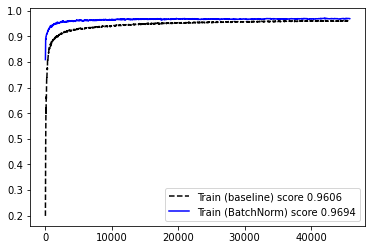

In [302]:
# Display activations

plt.plot(epoch_stat, val_stat, 'k--' ,label = f"Train (baseline) score {val_stat[-1]:.4f}")
plt.plot(bn_epoch_stat, bn_val_stat, 'b-' ,label = f"Train (BatchNorm) score {bn_val_stat[-1]:.4f}")

plt.legend()
plt.show()